In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import random


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI project/data_by_all_20230518.csv")

In [53]:
#월별 oil price data 생성
oil = df[['ID', 'oil_price']]

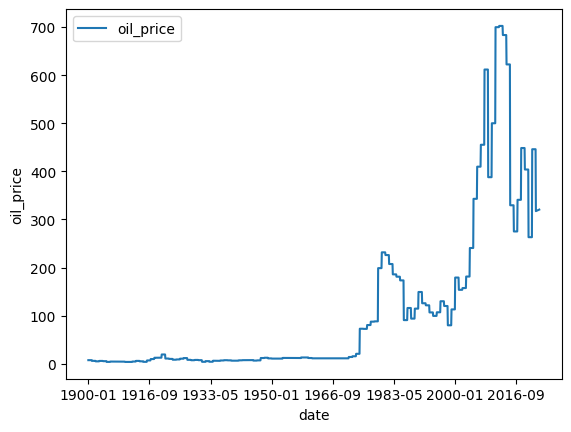

In [54]:
#x축 ID(1900-01 ~ 2022-12), y축이 oil price인 그래프 생성
oil.set_index(df['ID']).plot()
plt.xlabel('date')
plt.ylabel('oil_price')
plt.show()

In [55]:
#ID를 연, 월로 분리하고 int로 형변환해 [연, 월] 형태의 리스트 생성
date_strings = np.array([date.split('-') for date in oil['ID']])
dates = []
for date_string in date_strings:
    date = [int(val) for val in date_string]
    dates.append(date)

In [56]:
#input: 연 월, output(target): co2
X = np.array(dates)
y = oil['oil_price'].values

In [57]:
#input dimesion과 batch size, sequence 길이 설정
seq_length = 12
input_size = X.shape[1]
batch_size = 4

In [58]:
#원하는 sequence만큼 data를 이어줌 (num_data,sequence_length, input_size)형태)
def data_to_seq(data, input_size, seq_length):
    data_seq = np.array([])
    for i in range(0, data.shape[0] - (seq_length - 1)):
        data_seq = np.append(data_seq, data[i:i + seq_length])
    return data_seq.reshape(-1, seq_length, input_size)

In [59]:
#Minmax scaler를 통해 normalize
#나올 수 있는 모든 값들이 random하게 선택되었다는 가정하에 전체 데이터셋에 대하여 scaling 진행
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [60]:
#input data를 sequential하게 이어줌
X_seq = data_to_seq(data = X_scaled, input_size = input_size,seq_length = seq_length)

In [61]:
#train, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y[seq_length - 1:], test_size = 0.2, random_state = 0)

In [62]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [63]:
train = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)

test = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [64]:
#LSTM
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.lstm(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)

In [65]:
#RNN
class RNN_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(RNN_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_layer = torch.nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size) 
    def forward(self,x):
        x = x.to(device)
        y, hidden = self.rnn_layer(x)
        y = y[:,-1, :]
        y = self.fc(y)
        return y.view(-1)

In [66]:
#GRU
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.gru(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)


In [67]:
def train(model, dataloader, loss_fn, optim, epochs, device):
    model.train()
    num_batch = len(dataloader)
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            train_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        train_loss /= num_batch
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.8f}')
    return train_loss

In [68]:
def validation(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    num_batch = len(dataloader)
    with torch.no_grad():
        for x, y_true  in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            val_loss += loss.item()
    val_loss /= num_batch
    return val_loss

In [69]:
#learning late, hidden size, layer 수, output dimesion, epoch, device 설정
lr = 0.001
hidden_size = 20
num_layers = 1
output_size = 1
epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
#RNN 모델
model_1 = RNN_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_1 = torch.nn.MSELoss().to(device)
optim_1 = torch.optim.Adam(params=model_1.parameters(), lr = lr )


In [71]:
#LSTM 모델
model_2 = LSTM_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_2 = torch.nn.MSELoss().to(device)
optim_2 = torch.optim.Adam(params=model_2.parameters(), lr = lr )

In [72]:
#GRU 모델
model_3 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_3 = torch.nn.MSELoss().to(device)
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr = lr )

In [73]:
#RNN 모델 training
train(model = model_1, dataloader = train_dataloader, loss_fn = loss_func_1, optim = optim_1, epochs = epochs, device = device)

Epoch: 20, Train Loss: 28272.56369737
Epoch: 40, Train Loss: 20629.67893007
Epoch: 60, Train Loss: 16049.54676583
Epoch: 80, Train Loss: 12453.80615323
Epoch: 100, Train Loss: 12084.49518795
Epoch: 120, Train Loss: 7566.08730953
Epoch: 140, Train Loss: 5769.01202955
Epoch: 160, Train Loss: 4522.43222835
Epoch: 180, Train Loss: 4204.25829271
Epoch: 200, Train Loss: 5424.25957893
Epoch: 220, Train Loss: 5083.21454485
Epoch: 240, Train Loss: 4099.60464922
Epoch: 260, Train Loss: 3623.26545717
Epoch: 280, Train Loss: 3111.48624308
Epoch: 300, Train Loss: 3021.34021411
Epoch: 320, Train Loss: 3009.52752649
Epoch: 340, Train Loss: 3041.65669286
Epoch: 360, Train Loss: 2928.67698935
Epoch: 380, Train Loss: 2868.23509390
Epoch: 400, Train Loss: 3046.94733068
Epoch: 420, Train Loss: 2929.37779814
Epoch: 440, Train Loss: 3144.26287046
Epoch: 460, Train Loss: 3103.12896514
Epoch: 480, Train Loss: 3040.20410417
Epoch: 500, Train Loss: 2926.75777271


2926.757772707695

In [74]:
#LSTM 모델 training
train(model = model_2, dataloader = train_dataloader, loss_fn = loss_func_2, optim = optim_2, epochs = epochs, device = device)

Epoch: 20, Train Loss: 25214.40198209
Epoch: 40, Train Loss: 16776.73409029
Epoch: 60, Train Loss: 13019.33415082
Epoch: 80, Train Loss: 9950.59965034
Epoch: 100, Train Loss: 6265.73507930
Epoch: 120, Train Loss: 4484.66269610
Epoch: 140, Train Loss: 3590.29179824
Epoch: 160, Train Loss: 4815.45315906
Epoch: 180, Train Loss: 3685.73728960
Epoch: 200, Train Loss: 3144.16514859
Epoch: 220, Train Loss: 2608.85976693
Epoch: 240, Train Loss: 2640.56126944
Epoch: 260, Train Loss: 3223.33497026
Epoch: 280, Train Loss: 2453.70468330
Epoch: 300, Train Loss: 2738.44244179
Epoch: 320, Train Loss: 2661.29325719
Epoch: 340, Train Loss: 2618.59154385
Epoch: 360, Train Loss: 4373.70463583
Epoch: 380, Train Loss: 2468.25470537
Epoch: 400, Train Loss: 3369.67330050
Epoch: 420, Train Loss: 2956.94590219
Epoch: 440, Train Loss: 4017.14920619
Epoch: 460, Train Loss: 3659.40260032
Epoch: 480, Train Loss: 2518.93488205
Epoch: 500, Train Loss: 2111.27555467


2111.2755546679678

In [75]:
#GRU 모델 training
train(model = model_3, dataloader = train_dataloader, loss_fn = loss_func_3, optim = optim_3, epochs = epochs, device = device)

Epoch: 20, Train Loss: 24764.17252164
Epoch: 40, Train Loss: 16418.78680486
Epoch: 60, Train Loss: 12909.42076587
Epoch: 80, Train Loss: 8961.29953196
Epoch: 100, Train Loss: 5970.77726060
Epoch: 120, Train Loss: 4720.63093926
Epoch: 140, Train Loss: 3819.43739920
Epoch: 160, Train Loss: 3179.94855513
Epoch: 180, Train Loss: 3554.38037631
Epoch: 200, Train Loss: 3211.05478062
Epoch: 220, Train Loss: 3217.84721926
Epoch: 240, Train Loss: 3229.71282640
Epoch: 260, Train Loss: 3011.86716644
Epoch: 280, Train Loss: 2880.80955699
Epoch: 300, Train Loss: 2914.08612089
Epoch: 320, Train Loss: 2883.66495090
Epoch: 340, Train Loss: 2840.78555929
Epoch: 360, Train Loss: 2760.09081052
Epoch: 380, Train Loss: 2971.15154212
Epoch: 400, Train Loss: 3354.42316292
Epoch: 420, Train Loss: 3337.16439315
Epoch: 440, Train Loss: 1947.07687607
Epoch: 460, Train Loss: 2954.14053015
Epoch: 480, Train Loss: 2478.59261205
Epoch: 500, Train Loss: 2520.97410182


2520.9741018166314

In [76]:
#RNN 모델 test loss
validation(model_1, test_dataloader, loss_func_1, device)

5774.878764152527

In [77]:
#LSTM 모델 test loss
validation(model_2, test_dataloader, loss_func_2, device)

2629.6940045469514

In [78]:
#GRU 모델 test loss
validation(model_3, test_dataloader, loss_func_3, device)

3264.71225775738

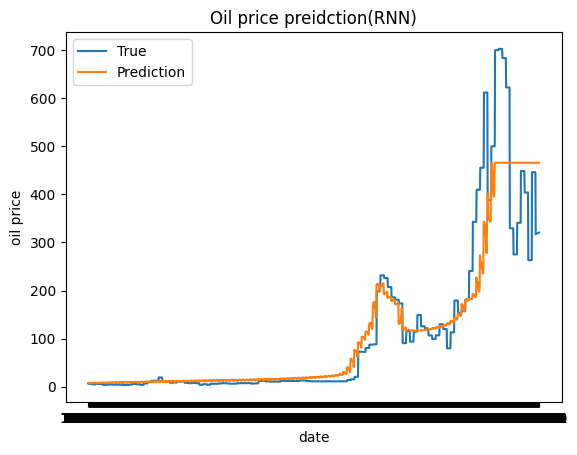

In [79]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 RNN모델 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length - 1:], oil['oil_price'][seq_length - 1:], label = 'True')
plt.plot(oil.ID.values[seq_length - 1:], model_1(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(RNN)')
plt.legend()
plt.show()

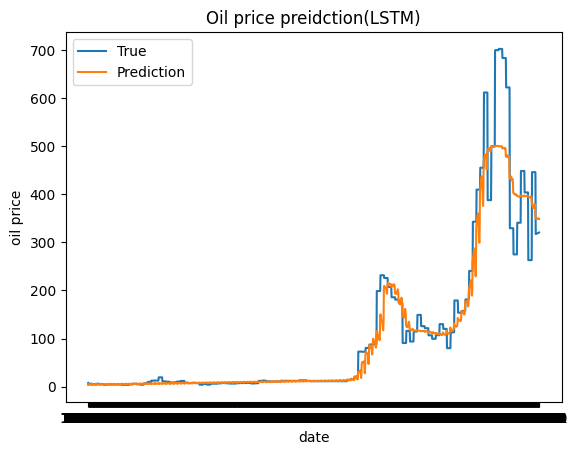

In [80]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 LSTM모델 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length - 1:], oil['oil_price'][seq_length - 1:], label = 'True')
plt.plot(oil.ID.values[seq_length - 1:], model_2(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(LSTM)')
plt.legend()
plt.show()

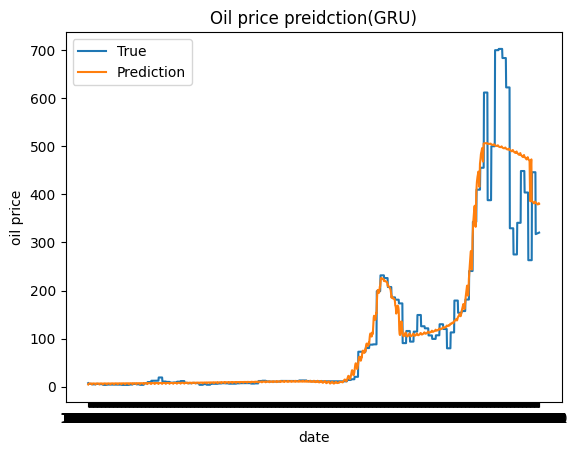

In [81]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 GRU모델 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length - 1:], oil['oil_price'][seq_length - 1:], label = 'True')
plt.plot(oil.ID.values[seq_length - 1:], model_3(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(GRU)')
plt.legend()
plt.show()

In [82]:
#RNN, LSTM, GRU을 ensemble한 model
class EnsembleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnsembleModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.rnn_model = RNN_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_rnn = self.rnn_model(x)
        output_lstm = self.lstm_model(x)

        output = torch.mean(torch.Floattensor(output_rnn,output_gru, output_lstm))

        return output

In [83]:
#LSTM, GRU을 ensemble한 model
class EnsembleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(EnsembleModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_lstm = self.lstm_model(x)

        output = torch.mean(torch.Floattensor(output_gru, output_lstm))

        return output

In [84]:
#Ensemble(RNN, LSTM, GRU)
model_4 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_4 = torch.nn.MSELoss().to(device)
optim_4 = torch.optim.Adam(params=model_4.parameters(), lr = lr )

In [85]:
#Ensemble(RNN, LSTM, GRU) 모델 training
train(model = model_4, dataloader = train_dataloader, loss_fn = loss_func_4, optim = optim_4, epochs = epochs, device = device)

Epoch: 20, Train Loss: 25025.18341919
Epoch: 40, Train Loss: 16567.14358588
Epoch: 60, Train Loss: 12889.03600455
Epoch: 80, Train Loss: 8898.25147228
Epoch: 100, Train Loss: 7073.71367879
Epoch: 120, Train Loss: 5135.86595767
Epoch: 140, Train Loss: 3935.93242365
Epoch: 160, Train Loss: 3311.52301217
Epoch: 180, Train Loss: 3181.45793423
Epoch: 200, Train Loss: 2672.11711119
Epoch: 220, Train Loss: 2212.74724288
Epoch: 240, Train Loss: 2106.14457324
Epoch: 260, Train Loss: 2125.25699673
Epoch: 280, Train Loss: 2096.42554267
Epoch: 300, Train Loss: 2272.31351393
Epoch: 320, Train Loss: 2389.26141082
Epoch: 340, Train Loss: 2478.01406856
Epoch: 360, Train Loss: 1377.85396777
Epoch: 380, Train Loss: 1663.20192436
Epoch: 400, Train Loss: 1247.54280428
Epoch: 420, Train Loss: 1573.65484307
Epoch: 440, Train Loss: 3117.81242499
Epoch: 460, Train Loss: 2107.92483412
Epoch: 480, Train Loss: 1990.74913576
Epoch: 500, Train Loss: 1680.59518813


1680.5951881302908

In [86]:
#Ensemble(RNN, LSTM, GRU) 모델 test loss
validation(model_4, test_dataloader, loss_func_4, device)

1698.6509897281994

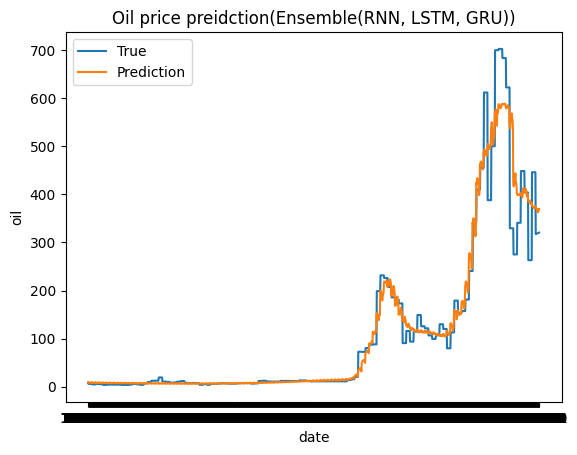

In [87]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 Ensemble모델(RNN, LSTM, GRU) 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length - 1:], oil['oil_price'][seq_length - 1:], label = 'True')
plt.plot(oil.ID.values[seq_length - 1:], model_4(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil')
plt.title('Oil price preidction(Ensemble(RNN, LSTM, GRU))')
plt.legend()
plt.show()

In [88]:
#Ensemble(LSTM, GRU)
model_5 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_5 = torch.nn.MSELoss().to(device)
optim_5 = torch.optim.Adam(params=model_5.parameters(), lr = lr )

In [89]:
#Ensemble(LSTM, GRU) 모델 training
train(model = model_5, dataloader = train_dataloader, loss_fn = loss_func_5, optim = optim_5, epochs = epochs, device = device)

Epoch: 20, Train Loss: 24955.20944141
Epoch: 40, Train Loss: 16478.28093260
Epoch: 60, Train Loss: 12929.13688071
Epoch: 80, Train Loss: 9560.63587799
Epoch: 100, Train Loss: 6953.57174485
Epoch: 120, Train Loss: 4846.02484720
Epoch: 140, Train Loss: 3705.65714736
Epoch: 160, Train Loss: 3478.64125407
Epoch: 180, Train Loss: 2976.15088746
Epoch: 200, Train Loss: 2934.26745134
Epoch: 220, Train Loss: 2861.83483031
Epoch: 240, Train Loss: 2714.31077649
Epoch: 260, Train Loss: 2857.75634335
Epoch: 280, Train Loss: 2414.66999359
Epoch: 300, Train Loss: 2349.29688440
Epoch: 320, Train Loss: 4643.34328273
Epoch: 340, Train Loss: 2971.70818869
Epoch: 360, Train Loss: 3348.94345521
Epoch: 380, Train Loss: 3166.06713596
Epoch: 400, Train Loss: 2891.89612783
Epoch: 420, Train Loss: 2798.52595912
Epoch: 440, Train Loss: 3276.90516856
Epoch: 460, Train Loss: 2364.78253889
Epoch: 480, Train Loss: 2324.22456856
Epoch: 500, Train Loss: 3028.86804806


3028.868048056604

In [90]:
#Ensemble(LSTM, GRU) 모델 test loss
validation(model_5, test_dataloader, loss_func_5, device)

4049.6154868075173

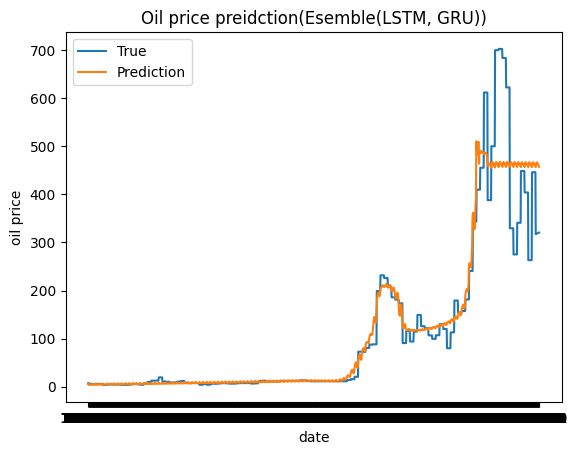

In [91]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 Ensemble모델(LSTM, GRU) 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length - 1:], oil['oil_price'][seq_length - 1:], label = 'True')
plt.plot(oil.ID.values[seq_length - 1:], model_5(torch.FloatTensor(X_seq)).cpu().detach().numpy(), label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(Esemble(LSTM, GRU))')
plt.legend()
plt.show()